In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!pip freeze > requirments.txt

In [2]:
# DATA_DIR = https://www.kaggle.com/c/sf-dst-scoring/data
# df_train = pd.read_csv(DATA_DIR+'/train.csv')
# df_test = pd.read_csv(DATA_DIR+'test.csv')

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:

df_train['sample'] = 1 # помечаем train
df_test['sample'] = 0 # помечаем test
df_test['default'] = 0 # в тесте нет значения default, его нужно предсказать

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем в единый датафрейм


In [171]:

def preparation(data):
# разберемся с данными об образовании. Предварительный анализ показал, что в графе "education" 
# указаны уровни образования: 
#'SCH' - у потенциального заёмщика имеется школьное образование,
#'UGR' - вероятно, начальное или среднее профессиональное образование,
#'GRD' - вероятно, бакалавриат
#'PGR' - вероятно, магистратура
#'ACD' - наличие академической (ученой) степени
# Предварительный анализ данных (df.groupby(['education']).income.mean()) также показал, 
# что доход заемщика в среднем тем выше, чем выше уровень его образования 
# Доход же, в свою очередь, влияет на возможность получения займа
# Таким образом, мы можем ввести следующую градацию, присвоив коэффициенты:
#'SCH' - коэффициент 0,
#'UGR' - коэффициент 1,
#'GRD' - коэффициент 2,
#'PGR' - коэффициент 3,
#'ACD' - коэффициент 4.
# По ряду заёмщиков отсутствует информация об образовании. Однако анализ таких заёмщиков показал, 
# что если убрать 11 заемщиков с неизвестным уровнем образования с максимальным доходом (превышающим 200 000; 
# кстати, по всем (5) таким заемщикам из датафрейма train не было дефолта), 
# то средний уровень дохода таких заемщиков будет чуть ниже заемщиков 'UGR', но будет близок к нему.
# Поэтому мы присвоим в колонке "образование" заемщикам с неизвестным его уровнем тот же коэффициент, что и 'UGR'

    data.education = data.education.fillna('unknown')
    for i in data.index: 
        if data['education'][i] == 'SCH':
            data['education'][i] = 0
        elif data['education'][i] == 'UGR' or data['education'][i] == 'unknown':
                data['education'][i] = 1
        elif data['education'][i] == 'GRD':
            data['education'][i] = 2  
        elif data['education'][i] == 'PGR':
            data['education'][i] = 3   
        else:
            data['education'][i] = 4
        
    data.education = data.education.astype(int)

# теперь разберемся с графой даты подачи заявки - 'app_date'. Предварительный анализ показал, что в этой графе 
# отражены исключительно даты в диапазоне первых 4 месяцев 2014 года. Соответственно, в итоге мы преобразуем 
# графу 'app_date' и оставим только графу "месяц" 

    for i in data.index: 
        data['app_date'][i] = datetime.strptime(data['app_date'][i], '%d%b%Y')   
    
    data['month'] = data['app_date']         
    
    for i in data.index: 
        data['month'][i] = data['app_date'][i].month         
        
    data.month = data.month.astype(int)
    
    cat_cols = ['home_address','work_address']
    OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values) # преобразуем буквенные обозначения в 
    # в столбцах, названия которых отнесены к переменной cat_cols, в цифровые значения  
    
    data['ones'] = 1 # здесь мы создаем еще одну колонку с единицами. Это согласно информации, 
    # представленной на обучении, так называемый "шум", не отраженный в признаках
    # и представляющий собой рассчитываемую моделью константу
    
    return data

preparation(df)


<ipython-input-171-95ad59318e94>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'][i] = 2
<ipython-input-171-95ad59318e94>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'][i] = 0
<ipython-input-171-95ad59318e94>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'][i] = 1
<ipython-input-171-95ad59318e94>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,month,ones
0,74835,2014-03-22 00:00:00,2,M,29,Y,Y,0,0,-2.271884,...,1,2,50000,1,4,N,0,0,3,1
1,17527,2014-01-24 00:00:00,0,F,39,N,N,5,0,-1.504999,...,1,2,5000,4,3,N,0,0,1,1
2,75683,2014-03-23 00:00:00,1,M,50,Y,Y,0,0,-1.691339,...,1,2,30000,1,3,Y,0,0,3,1
3,26883,2014-02-03 00:00:00,0,M,56,N,N,0,0,-2.374182,...,1,2,17000,1,3,N,0,0,2,1
4,28862,2014-02-04 00:00:00,2,F,38,N,N,0,0,-2.487502,...,2,3,120000,1,3,N,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04 00:00:00,2,F,45,N,N,0,0,-1.792064,...,1,2,17000,4,4,N,1,0,3,1
110144,76821,2014-03-24 00:00:00,0,M,41,Y,Y,0,0,-2.058029,...,2,2,70000,1,4,N,1,0,3,1
110145,103695,2014-04-22 00:00:00,0,M,31,N,N,0,0,-1.512635,...,2,3,45000,2,2,N,1,0,4,1
110146,861,2014-01-04 00:00:00,0,F,29,N,N,0,1,-1.479334,...,1,3,13000,2,3,N,1,1,1,1


In [172]:
preparation(df_train)

<ipython-input-171-95ad59318e94>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'][i] = 0
<ipython-input-171-95ad59318e94>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'][i] = 2
<ipython-input-171-95ad59318e94>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education'][i] = 1
<ipython-input-171-95ad59318e94>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,month,ones
0,25905,2014-02-01 00:00:00,0,M,62,Y,Y,0,0,-2.008753,...,1,2,18000,4,1,N,0,1,2,1
1,63161,2014-03-12 00:00:00,0,F,59,N,N,0,0,-1.532276,...,2,3,19000,4,1,N,0,1,3,1
2,25887,2014-02-01 00:00:00,0,M,25,Y,N,2,0,-1.408142,...,1,2,30000,1,4,Y,0,1,2,1
3,16222,2014-01-23 00:00:00,0,F,53,N,N,0,0,-2.057471,...,2,3,10000,1,3,N,0,1,1,1
4,101655,2014-04-18 00:00:00,2,M,48,N,N,0,1,-1.244723,...,2,3,30000,1,4,Y,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04 00:00:00,2,F,45,N,N,0,0,-1.792064,...,1,2,17000,4,4,N,0,1,3,1
73795,76821,2014-03-24 00:00:00,0,M,41,Y,Y,0,0,-2.058029,...,2,2,70000,1,4,N,0,1,3,1
73796,103695,2014-04-22 00:00:00,0,M,31,N,N,0,0,-1.512635,...,2,3,45000,2,2,N,0,1,4,1
73797,861,2014-01-04 00:00:00,0,F,29,N,N,0,1,-1.479334,...,1,3,13000,2,3,N,1,1,1,1


Применение поиска выбросов по IQR:

columns_for_IQR = ['income','bki_request_cnt','decline_app_cnt']
for i in columns_for_IQR:
    IQR = data[i].quantile(0.75) - data[i].quantile(0.25)
    perc25 = data[i].quantile(0.25)
    perc75 = data[i].quantile(0.75)
    data[i] = data[i].loc[data[i].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
data_clear = data.dropna()

Применение указанного подхода выявило, что слишком много данных не входят в диапазон between(perc25 - 1.5*IQR, perc75 + 1.5*IQR). Их количество по указанным выше признакам 'income','bki_request_cnt','decline_app_cnt' исчисляется тысячами. Исключение этих данных может существенно повлиять на качество модели. Поэтому такая технология устранения выбросов не применена

Пытался определить выбросы иным образом. Например, эксперементировал с чуть сокращенным датафреймом, исключив только около 1000 наблюдений, в которых доход более 300000, 'bki_request_cnt' больше 14, 
а 'decline_app_cnt' больше 5. На корреляционной матрице эти признаки показали более высокую корреляционную связь с целевой переменной.
Но метрики модели показали более низкие значения. Пришлось отказаться от идеи исключения выбросов


<AxesSubplot:>

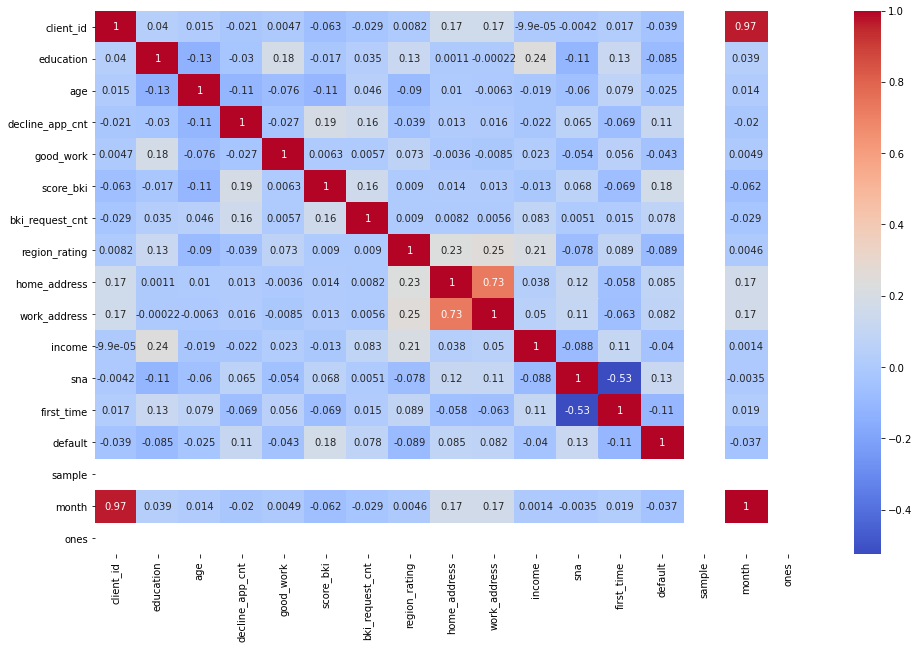

In [173]:
# посмотрим корреляционную матрицу на тренировочном датафрейме без обработки бинарных признаков:
# sex, car, car_type, foreign_passport

corr_scoring = df_train.corr()
plt.figure(figsize=(16, 10)) # увеличиваем размер теповой карты
sns.heatmap(corr_scoring, annot=True, cmap='coolwarm')

К сожалению, мои попытки выявить какие-то значимые закономерности в признаках, создать новые признаки и устранить малозначимые признаки к улучшению качества модели не привели. Кстати, и применение гиперпараметров почти не улучшило модель. 

Напротив, следуя логике устранения одного из сильно коррелируюрующих друг с другом признаков (например, 'work_address' и'home_address'), я приходил к результатам, снижающим качество модели, в том числе значения показателя ROC и других метрик из sklearn.metrics согласно classification_report. 

Вместе с тем, я решил, что даже, если не добиваюсь роста значения ROC и других метрик, я должен делать так, как меня учили.
Поэтому я убрал из датафрейма признак 'work_address', так как его корреляционная связь с целевой переменной 'default' меньше, чем у признака 'home_address'. А корреляционная связь между 'work_address' и 'home_address' очень высокая.

Кроме того, поскольку есть очень существенная корреляционная (обратная пропорциональная) связь между признаками 'sna' и 'first_time', я решил, что будет более правильно вместо двух признаков использовать один признак, объединяющий оба признака.

In [174]:
def new_feature(data):
    data['sna/first_time'] = data['sna'] / data['first_time'] # поскольку корреляционная связь 
    # между 'sna' и 'first_time' обратная, мне показалось целесообразной замена двух этих признаков, 
    # на один, представляющий собой деление одного признака на другой
    
    return data

new_feature(df)
new_feature(df_train)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,sample,month,ones,sna/first_time
0,25905,2014-02-01 00:00:00,0,M,62,Y,Y,0,0,-2.008753,...,2,18000,4,1,N,0,1,2,1,4.000000
1,63161,2014-03-12 00:00:00,0,F,59,N,N,0,0,-1.532276,...,3,19000,4,1,N,0,1,3,1,4.000000
2,25887,2014-02-01 00:00:00,0,M,25,Y,N,2,0,-1.408142,...,2,30000,1,4,Y,0,1,2,1,0.250000
3,16222,2014-01-23 00:00:00,0,F,53,N,N,0,0,-2.057471,...,3,10000,1,3,N,0,1,1,1,0.333333
4,101655,2014-04-18 00:00:00,2,M,48,N,N,0,1,-1.244723,...,3,30000,1,4,Y,0,1,4,1,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04 00:00:00,2,F,45,N,N,0,0,-1.792064,...,2,17000,4,4,N,0,1,3,1,1.000000
73795,76821,2014-03-24 00:00:00,0,M,41,Y,Y,0,0,-2.058029,...,2,70000,1,4,N,0,1,3,1,0.250000
73796,103695,2014-04-22 00:00:00,0,M,31,N,N,0,0,-1.512635,...,3,45000,2,2,N,0,1,4,1,1.000000
73797,861,2014-01-04 00:00:00,0,F,29,N,N,0,1,-1.479334,...,3,13000,2,3,N,1,1,1,1,0.666667


In [175]:
# удаляем ненужные столбцы
df = df.drop(['app_date','sna','first_time','work_address'], axis=1)
    
df = pd.get_dummies(df) # вводим dummy-значения для бинарных признаков:
    # sex, car, car_type, foreign_passport
df

,client_id,education,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,...,ones,sna/first_time,sex_F,sex_M,car_N,car_Y,car_type_N,car_type_Y,foreign_passport_N,foreign_passport_Y
0,74835,2,29,0,0,-2.271884,3,50,1,50000,...,1,0.250000,0,1,0,1,0,1,1,0
1,17527,0,39,5,0,-1.504999,2,50,1,5000,...,1,1.333333,1,0,1,0,1,0,1,0
2,75683,1,50,0,0,-1.691339,1,50,1,30000,...,1,0.333333,0,1,0,1,0,1,0,1
3,26883,0,56,0,0,-2.374182,1,40,1,17000,...,1,0.333333,0,1,1,0,1,0,1,0
4,28862,2,38,0,0,-2.487502,0,80,2,120000,...,1,0.333333,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2,45,0,0,-1.792064,3,50,1,17000,...,1,1.000000,1,0,1,0,1,0,1,0
110144,76821,0,41,0,0,-2.058029,1,50,2,70000,...,1,0.250000,0,1,0,1,0,1,1,0
110145,103695,0,31,0,0,-1.512635,4,80,2,45000,...,1,1.000000,0,1,1,0,1,0,1,0
110146,861,0,29,0,1,-1.479334,3,50,1,13000,...,1,0.666667,1,0,1,0,1,0,1,0


In [179]:
df_train = df_train.drop(['client_id','app_date','sna','first_time','work_address'], axis=1)
    
df_train = pd.get_dummies(df_train) # вводим dummy-значения для бинарных признаков:
    # sex, car, car_type, foreign_passport
df_train

,education,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,default,...,ones,sna/first_time,sex_F,sex_M,car_N,car_Y,car_type_N,car_type_Y,foreign_passport_N,foreign_passport_Y
0,0,62,0,0,-2.008753,1,50,1,18000,0,...,1,4.000000,0,1,0,1,0,1,1,0
1,0,59,0,0,-1.532276,3,50,2,19000,0,...,1,4.000000,1,0,1,0,1,0,1,0
2,0,25,2,0,-1.408142,1,80,1,30000,0,...,1,0.250000,0,1,0,1,1,0,0,1
3,0,53,0,0,-2.057471,2,50,2,10000,0,...,1,0.333333,1,0,1,0,1,0,1,0
4,2,48,0,1,-1.244723,1,60,2,30000,0,...,1,0.250000,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,2,45,0,0,-1.792064,3,50,1,17000,0,...,1,1.000000,1,0,1,0,1,0,1,0
73795,0,41,0,0,-2.058029,1,50,2,70000,0,...,1,0.250000,0,1,0,1,0,1,1,0
73796,0,31,0,0,-1.512635,4,80,2,45000,0,...,1,1.000000,0,1,1,0,1,0,1,0
73797,0,29,0,1,-1.479334,3,50,1,13000,1,...,1,0.666667,1,0,1,0,1,0,1,0


<AxesSubplot:>

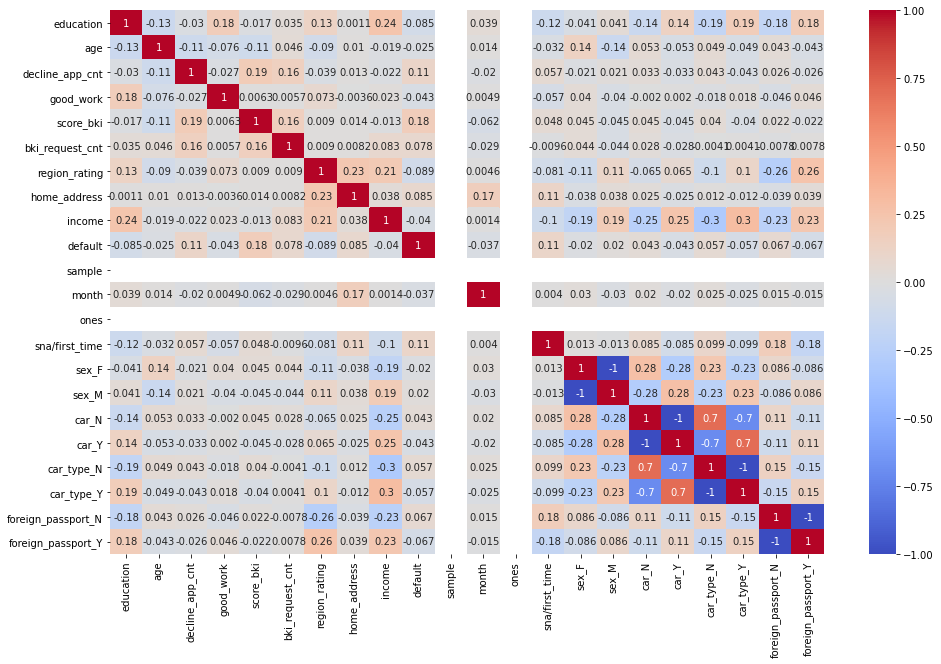

In [180]:
corr_scoring = df_train.corr()
plt.figure(figsize=(16, 10)) # увеличиваем размер теповой карты
sns.heatmap(corr_scoring, annot=True, cmap='coolwarm')

Теперь у нас все признаки представлены в виде чисел. Поэтому у нас нет необходимости вводить 3 категории переменных:
- cat_cols,
- num_cols
- bin_cols
Введем единную переменную - cols

In [181]:
cols = ['education','age','decline_app_cnt','score_bki','bki_request_cnt','region_rating',
              'home_address','income','month','ones','sna/first_time','sex_F','sex_M',
        'car_N','car_Y','car_type_N','car_type_Y','foreign_passport_N','foreign_passport_Y'] 

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. 
Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

Теперь определим важность признаков функцией mutual_info_classif

/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

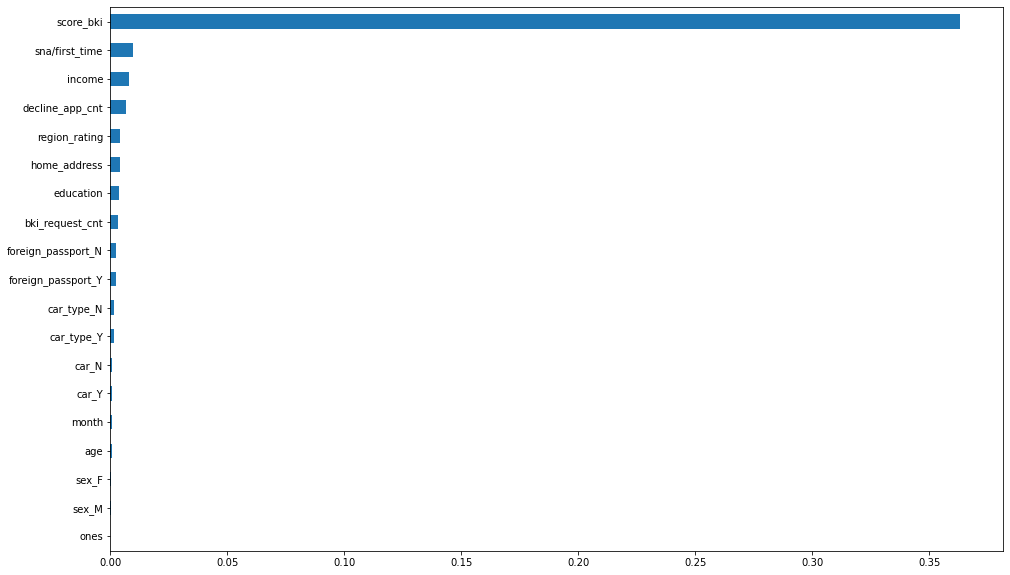

In [182]:
imp_cat = Series(mutual_info_classif(df_train.query('sample == 1')[cols], 
                                     df_train.query('sample == 1')['default'], discrete_features =True), 
                 index = cols)
imp_cat.sort_values(inplace = True)
plt.figure(figsize=(16, 10))
imp_cat.plot(kind = 'barh')

In [183]:
train = df.query('sample == 1')[cols] # датафрейм для обучения

test = df.query('sample == 0')[cols] # тестовый датафрейм

In [184]:
X = train.values # выделяем значения признаков, на которых будет обучаться модель

Y = df.query('sample == 1').default.values # выделяем значения известной целевой переменной

# делим выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# стандартизируем признаки
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


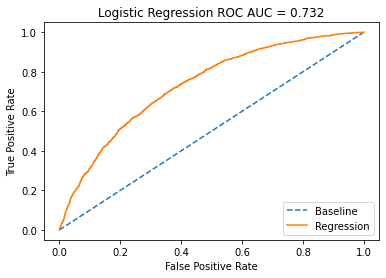

In [185]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [27]:
penalty = ['l1', 'l2']
solvers = ['liblinear', 'sag']
iters = [100,500,1000]
C = np.logspace(0, 4, 50)

hyperparameters = dict(C=C, penalty=penalty, solver=solvers, max_iter=iters)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty']) # l2
print('Лучшее C:', best_model.best_estimator_.get_params()['C']) # 1.0
print('Лучшее solvers:', best_model.best_estimator_.get_params()['solver']) # liblinear
print('Лучшее max_iter:', best_model.best_estimator_.get_params()['max_iter']) # 100

/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/imac/anaconda3/lib/python3.8/site-pa

Лучшее Penalty: l1
Лучшее C: 1.0
Лучшее solvers: liblinear
Лучшее max_iter: 100


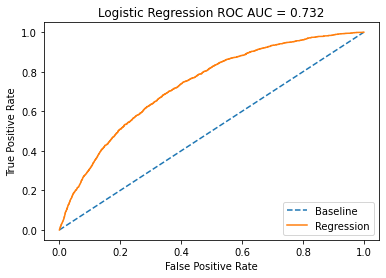

In [186]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', C=1.0, penalty='l2', max_iter=100)
model.fit(X_train, y_train)

probs = model.predict(X_test)
pred_probs = model.predict_proba(X_test)

fpr, tpr, threshold = roc_curve(y_test, pred_probs[:,1])
roc_auc = roc_auc_score(y_test, pred_probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


In [187]:
y_pred = probs
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.93      0.67      0.78     12933
     class 1       0.22      0.67      0.33      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760



Понимаю, что модель получилась довольно посредственная. Но не смогу придумать, как её улучшить, как не пытался.
Очевидно, не хватило навыков, времени, и, возможно, идей для проверки. 

In [189]:
sub_test = test.values
submission = df.query('sample == 0')[['client_id', 'default']]
submission['default'] = model.predict_proba(sub_test)[:,1]
display(submission.sample(10))

submission.to_csv('submission.csv', index=False)

,client_id,default
15920,104665,1.0
7185,97596,1.0
27105,28582,1.0
2793,100221,1.0
25403,64344,1.0
22329,32395,1.0
29175,4691,1.0
25444,34010,1.0
12999,63113,1.0
33565,31428,1.0
